# Assignment 3 Implementation Questions

## Question 1 
### In this question, you will explore the concept of Transfer Learning (TL) using PyTorch. TL is a technique in which previously trained models can be used to help train new models. There are two possible ways to implemented TL, namely Fine-tuning and Feature Extraction. You can read more about these methods by referring to PyTorch documentations. For the following questions, you are to use the Brain Tumor classification dataset available on Kaggle. Sample images are shown below for the 4 different classes.

In [28]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import sklearn

torch.manual_seed(0)


In [29]:
def get_resnet_model(_use_weights = True):
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) if _use_weights else torchvision.models.resnet18(weights=None, num_classes=4)
    if _use_weights:
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 4)

    return model


def plot_results(_train_losses, _train_accuracies, _test_losses, _test_accuracies, _num_batches, _batch_size, _weights_name):
    plt.style.use('seaborn-v0_8-dark')

    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    loss_ax.plot(np.arange(1, len(_train_losses) + 1), _train_losses, label=f"Training")
    loss_ax.plot(np.arange(1, len(_test_losses) + 1), _test_losses, label=f"Testing")
    loss_ax.set_xlabel(f"Epoch (Minibatch size = {_num_batches}, Batch size = {_batch_size})")
    loss_ax.set_xticks(np.arange(1, len(_train_losses) + 1))
    loss_ax.set_ylabel("CCE Loss")
    loss_ax.set_title(f"Epoch vs. Loss for ResNet 18 w/{_weights_name})")
    loss_ax.legend()
    loss_ax.grid()

    acc_ax.plot(np.arange(1, len(_train_accuracies) + 1), _train_accuracies, label="Training")
    acc_ax.plot(np.arange(1, len(_test_accuracies) + 1), _test_accuracies, label="Testing")
    acc_ax.set_xlabel(f"Epoch (Minibatch size = {_num_batches}, Batch size = {_batch_size})")
    acc_ax.set_xticks(np.arange(1, len(_train_accuracies) + 1))
    acc_ax.set_ylabel("Accuracy (%)")
    acc_ax.set_yticks(np.arange(0, 110, 10))
    acc_ax.set_title(f"Epoch vs. Accuracy for ResNet 18 w/{_weights_name})")
    loss_ax.legend()
    acc_ax.grid()

    plt.show()


def do_fit(_model, _train_loader, _test_loader, _num_epochs, _optimizer, _device, _weights_name):
    # Establish lists and running totals
    epoch_train_losses = []
    epoch_train_accuracies = []
    
    epoch_test_losses = []
    epoch_test_accuracies = []

    _model.to(_device)

    # Start epoch loop
    for epoch in range(_num_epochs):
        total_train_loss = 0.0
        total_train_accuracy = 0.0

        # Train mode
        _model.train()

        # Start batch train
        for data, labels in _train_loader:
            # Set to right device
            data, labels = data.to(_device), labels.to(_device)

            # Zero out optimizer
            _optimizer.zero_grad()

            # Forward pass
            logits = _model(data)
            # Get loss
            batch_loss = torch.nn.functional.cross_entropy(logits, labels)
            # Backprop
            batch_loss.backward()
            
            # Weight update
            _optimizer.step()

            # Get accuracy
            batch_accuracy = ((torch.argmax(torch.softmax(logits, dim=1), dim=1) == labels).sum().item() / len(labels)) * 100

            # Add to running totals
            total_train_loss += batch_loss.item()
            
            total_train_accuracy += batch_accuracy
        
        # Average out running totals
        epoch_train_losses.append(total_train_loss / len(_train_loader))
        
        epoch_train_accuracies.append(total_train_accuracy / len(_train_loader))

        print(f"[Question 1/do_fit] -- Finished train epoch, loss = {epoch_train_losses[epoch]:.4f} accuracy = {epoch_train_accuracies[epoch]:.2f}%")

        total_test_loss = 0.0
        total_test_accuracy = 0.0

        # Test mode
        _model.eval()

        # Start batch train
        for data, labels in _test_loader:
            # Set to right device
            data, labels = data.to(_device), labels.to(_device)

            # Forward pass
            logits = _model(data)
            # Get loss
            batch_loss = torch.nn.functional.cross_entropy(logits, labels).item()
            
            # Get accuracy
            batch_accuracy = ((torch.argmax(torch.softmax(logits, dim=1), dim=1) == labels).sum().item() / len(labels)) * 100

            # Add to running totals
            total_test_loss += batch_loss

            total_test_accuracy += batch_accuracy
        
        # Average out running totals
        epoch_test_losses.append(total_test_loss / len(_test_loader))
        
        epoch_test_accuracies.append(total_test_accuracy / len(_test_loader))

        print(f"[Question 1/do_fit] -- Finished test epoch, loss = {epoch_test_losses[epoch]:.4f} accuracy = {epoch_test_accuracies[epoch]:.2f}%\n")
    
    print(f"[Question 1/do_fit] -- Finished all epochs, plotting results...")

    # Plot curves
    plot_results(epoch_train_losses, epoch_train_accuracies, epoch_test_losses, epoch_test_accuracies, len(_train_loader), 16, _weights_name)


#### a) Analyze and visualize the statistics of the dataset. Pre-process the data and prepare them for the training phase. Ensure that the images are resized to 224x224x3 and normalized. Split the data randomly into train and test sets, with a ratio of 7:3.

In [30]:
import torch.utils
import torch.utils.data

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # ResNet
    torchvision.transforms.RandomHorizontalFlip(),  # Data augmentation
    torchvision.transforms.ToTensor(),  
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
])
full_dataset = torchvision.datasets.ImageFolder("Data", transforms)
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, 16, True)
test_loader = torch.utils.data.DataLoader(test_dataset, 16, True)

sample_data, sample_target = next(iter(train_loader))
print(f"sample_data.shape: {sample_data.shape}")

print(f"sample_target.shape: {sample_target.shape}")

print(f"sample_data mean: {sample_data.view((-1, 3*224*224)).mean(dim=0)}")

print(f"sample_data std: {sample_data.view((-1, 3*224*224)).std(dim=0)}")

print(f"{len(train_dataset)} + {len(test_dataset)} = {len(full_dataset)}? {len(train_dataset) + len(test_dataset) == len(full_dataset)}")

print(f"{len(train_dataset)} / {len(full_dataset)} = {len(train_dataset) / len(full_dataset)}")


sample_data.shape: torch.Size([16, 3, 224, 224])
sample_target.shape: torch.Size([16])
sample_data mean: tensor([-2.1179, -2.1179, -2.1179,  ..., -1.8044, -1.8044, -1.8044])
sample_data std: tensor([0., 0., 0.,  ..., 0., 0., 0.])
2167 + 929 = 3096? True
2167 / 3096 = 0.6999354005167958


- Due to the normalization of the data, the variance is greatly minimalized, this can help to ensure a faster convergence to a local minima

#### b) Train a ResNet-18 model from scratch using the provided dataset for the classification task. You are free to choose the hyperparameters (batch size, learning rate, optimizer, loss function, etc).

[Question 1] -- Starting training and testing for ResNet18 w/random weights...

[Question 1/do_fit] -- Finished train epoch, loss = 1.1333 accuracy = 55.37%
[Question 1/do_fit] -- Finished test epoch, loss = 3.9444 accuracy = 32.52%

[Question 1/do_fit] -- Finished train epoch, loss = 0.8988 accuracy = 62.83%
[Question 1/do_fit] -- Finished test epoch, loss = 2.3443 accuracy = 42.37%

[Question 1/do_fit] -- Finished train epoch, loss = 0.8136 accuracy = 67.41%
[Question 1/do_fit] -- Finished test epoch, loss = 1.0230 accuracy = 64.72%

[Question 1/do_fit] -- Finished train epoch, loss = 0.7122 accuracy = 71.68%
[Question 1/do_fit] -- Finished test epoch, loss = 1.9315 accuracy = 58.05%

[Question 1/do_fit] -- Finished train epoch, loss = 0.6574 accuracy = 74.24%
[Question 1/do_fit] -- Finished test epoch, loss = 0.6764 accuracy = 75.42%

[Question 1/do_fit] -- Finished all epochs, plotting results...


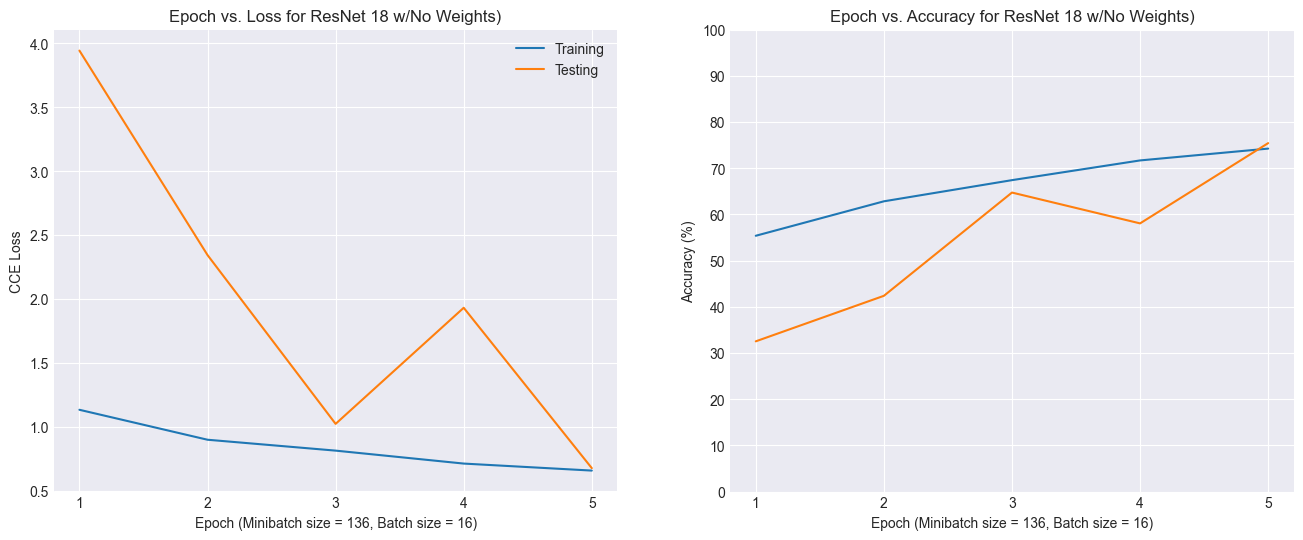

[Question 1] -- Finished training and testing for ResNet18 w/random weights!


In [32]:
print(f"[Question 1] -- Starting training and testing for ResNet18 w/random weights...\n")

fresh_resnet_model = get_resnet_model(False)
do_fit(fresh_resnet_model, train_loader, test_loader, 5, torch.optim.Adam(fresh_resnet_model.parameters()), "cuda:0", "No Weights")

print(f"[Question 1] -- Finished training and testing for ResNet18 w/random weights!")


#### c) Train another ResNet-18 model using the fine-tuning TL method based on IMAGENET1K weights. You should use the same hyperparameters and same data used to train the previous ResNet-18 model.

[Question 1] -- Starting training and testing for ResNet18 w/ImageNet weights...

[Question 1/do_fit] -- Finished train epoch, loss = 0.6862 accuracy = 73.96%
[Question 1/do_fit] -- Finished test epoch, loss = 1.5949 accuracy = 68.22%

[Question 1/do_fit] -- Finished train epoch, loss = 0.4546 accuracy = 83.76%
[Question 1/do_fit] -- Finished test epoch, loss = 0.3140 accuracy = 89.30%

[Question 1/do_fit] -- Finished train epoch, loss = 0.3819 accuracy = 86.63%
[Question 1/do_fit] -- Finished test epoch, loss = 0.5488 accuracy = 79.13%

[Question 1/do_fit] -- Finished train epoch, loss = 0.3610 accuracy = 88.05%
[Question 1/do_fit] -- Finished test epoch, loss = 0.4177 accuracy = 85.38%

[Question 1/do_fit] -- Finished train epoch, loss = 0.2007 accuracy = 93.23%
[Question 1/do_fit] -- Finished test epoch, loss = 0.4450 accuracy = 84.53%

[Question 1/do_fit] -- Finished all epochs, plotting results...


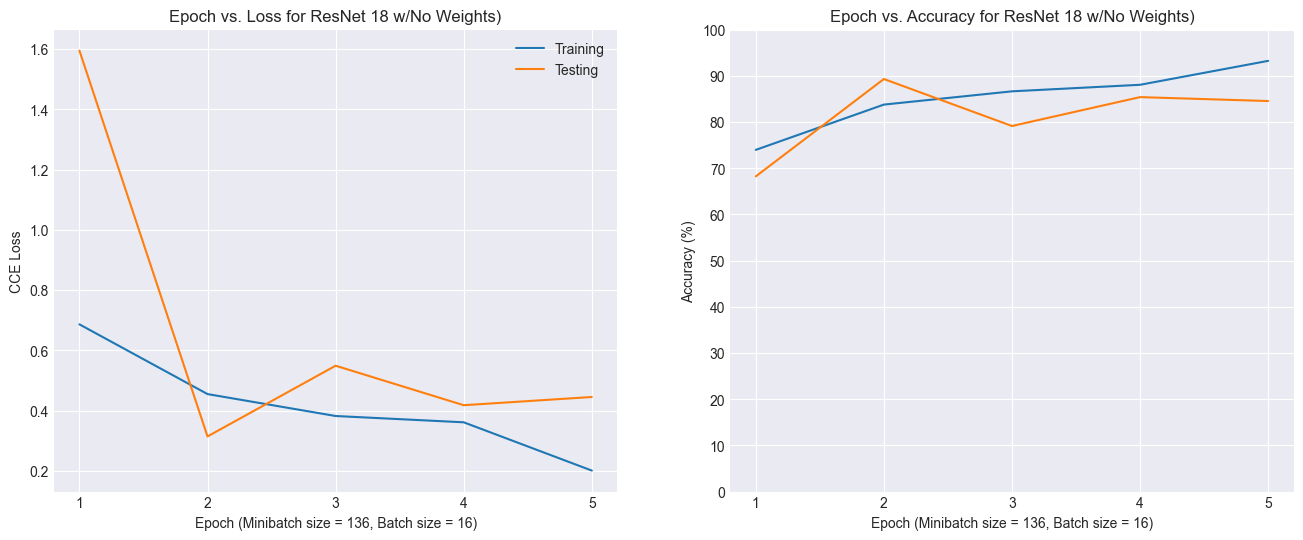

[Question 1] -- Finished training and testing for ResNet18 w/ImageNet weights!


In [33]:
print(f"[Question 1] -- Starting training and testing for ResNet18 w/ImageNet weights...\n")

imagenet_resnet_model = get_resnet_model()
do_fit(imagenet_resnet_model, train_loader, test_loader, 5, torch.optim.Adam(imagenet_resnet_model.parameters()), "cuda:0", "No Weights")

print(f"[Question 1] -- Finished training and testing for ResNet18 w/ImageNet weights!")


#### d) Report and compare the performance of both models in terms of training accuracy/loss and classification report. What are your conclusions?

In [38]:
import sklearn.metrics

test_sample_data, test_sample_target = next(iter(test_loader))
test_sample_data, test_sample_target = test_sample_data.to("cuda:0"), test_sample_target.to("cuda:0")

fresh_model_predictions = torch.argmax(torch.softmax(fresh_resnet_model(test_sample_data), dim=1), dim=1)

imagenet_model_predictions = torch.argmax(torch.softmax(imagenet_resnet_model(test_sample_data), dim=1), dim=1)

print("Fresh ResNet Model Classification Report:\n")

print(sklearn.metrics.classification_report(test_sample_target.cpu(), fresh_model_predictions.cpu()))

print("ImageNet ResNet Model Classification Report:\n")

print(sklearn.metrics.classification_report(test_sample_target.cpu(), imagenet_model_predictions.cpu()))


Fresh ResNet Model Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.75      1.00      0.86         3
           2       1.00      0.50      0.67         2
           3       0.78      1.00      0.88         7

    accuracy                           0.81        16
   macro avg       0.88      0.75      0.77        16
weighted avg       0.86      0.81      0.79        16

ImageNet ResNet Model Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.60      1.00      0.75         3
           2       1.00      1.00      1.00         2
           3       1.00      0.71      0.83         7

    accuracy                           0.88        16
   macro avg       0.90      0.93      0.90        16
weighted avg       0.93      0.88      0.88        16



- From the results of the graphs and classification reports, it is clear that the ImageNet model did much better than training a model from scratch. Likely due to the much broader training data provided
- Additionally, the ImageNet model had a harder time predicting meningioama tumor images in terms of precision and f1 while the fresh model had a more difficulties overall. This suggests that the CNN encoder of the ImageNet model may have been picking up on better features that allowed the FC layer to better classify. 

## Question 2
### Build an LSTM-based model for time-series forecasting using PyTorch. Given a series of data points, the model should be able to predict the next data point. You should use the Amazon Stock dataset for this task, where the aim is to use the previous data points to predict the next stock value.

In [1]:
import math
import numpy
import pandas
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler


#### a) We will only use the "close" column to train our model, hence you should remove the remaining columns from the dataset. Additionally, since our prediction is based on the historical trend, each data point (each row) in the dataset should be in the form of sequence -> prediction. Assume we want to use a sequence window of size 10 in this problem. Preprocess the dataset such that each sequence of 10 values is used to predict the 11th value. Youcan refer to this article for some examples on how to preprocess the data into sequences. (hint: if your original dataset has 100 data points, then the preprocessed dataset would have 100-10=90 data points/sequences).

In [2]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        X.append(feature)
        
        target = dataset[i+1:i+lookback+1]
        y.append(target)
        
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


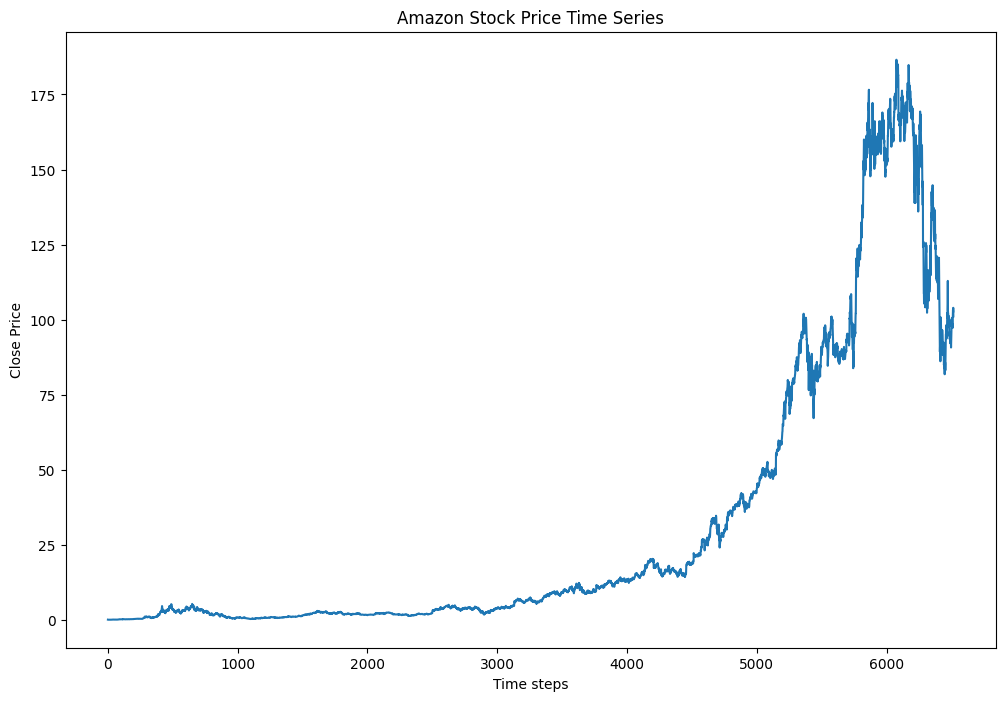

C:\Users\trist\AppData\Local\Temp\ipykernel_22132\2073512747.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [3]:
amazon_stock_series = pandas.read_csv("AMZN.csv").Close
plt.figure(figsize=(12,8))
plt.plot(amazon_stock_series)
plt.xlabel("Time steps")
plt.ylabel("Close Price")
plt.title("Amazon Stock Price Time Series")
plt.show()

look_back_window = 10

'''
https://stackoverflow.com/questions/61565156/why-pandas-core-series-series-sometimes-cannot-convert-to-torch-tensor-in-python
Had to convert series into numpy first due to pytorch expecting 0 index to exist per slice 
'''
train_data, train_target = create_dataset(amazon_stock_series.to_numpy(), look_back_window)


#### b) Preprocess the data using the MinMaxScaler from scikit-learn. There is no need to split or shuffle the data for this question.

In [4]:
scaler = MinMaxScaler()
train_data = torch.tensor(scaler.fit_transform(train_data, train_target), dtype=torch.float32)


#### c) Train a vanilla LSTM to forecast the price of amazon stock based on the last 10 values. You can refer to this article for some guidance. You are free to choose and optimize the hyperparameters (optimizer, batch size, etc), but you should use the MSE loss. Aim for better performance.

In [5]:
class AmazonStockModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=10, hidden_size=50, num_layers=1, batch_first=True, dtype=torch.float32)
        self.linear = torch.nn.Linear(50, 10, dtype=torch.float32)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    

In [6]:
device = "cuda:0"

stock_model = AmazonStockModel()
stock_model.to(device)

optimizer = torch.optim.Adam(stock_model.parameters())

loss_fn = torch.nn.MSELoss()

batch_size = 8

num_epochs = 100

num_minibatches = math.ceil(len(train_data) / batch_size)

training_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0

    for i in range(0, train_data.shape[0], batch_size):
        X = train_data[i:i+batch_size].to(device)
        y = train_target[i:i+batch_size].to(device)

        optimizer.zero_grad()

        output = stock_model(X)
        loss = loss_fn(output, y).to(torch.float32)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    training_losses.append(total_loss / num_minibatches)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss (MSE) = {training_losses[epoch]}")


Epoch 0: loss (MSE) = 1340.610925357402
Epoch 10: loss (MSE) = 60.54303966262904
Epoch 20: loss (MSE) = 16.498384353086635
Epoch 30: loss (MSE) = 7.416391386254491
Epoch 40: loss (MSE) = 5.861858616959254
Epoch 50: loss (MSE) = 4.618589000535857
Epoch 60: loss (MSE) = 2.8500965252009944
Epoch 70: loss (MSE) = 2.700155133625901
Epoch 80: loss (MSE) = 2.5647406308499567
Epoch 90: loss (MSE) = 2.448153808946934


#### d) Analyze the performance of your model by plotting the training loss. Using the available data, compare the original plot of the data points with the predicted plot (each data point on the predicted plot is obtained by feeding the previous 10 data points from the original data).

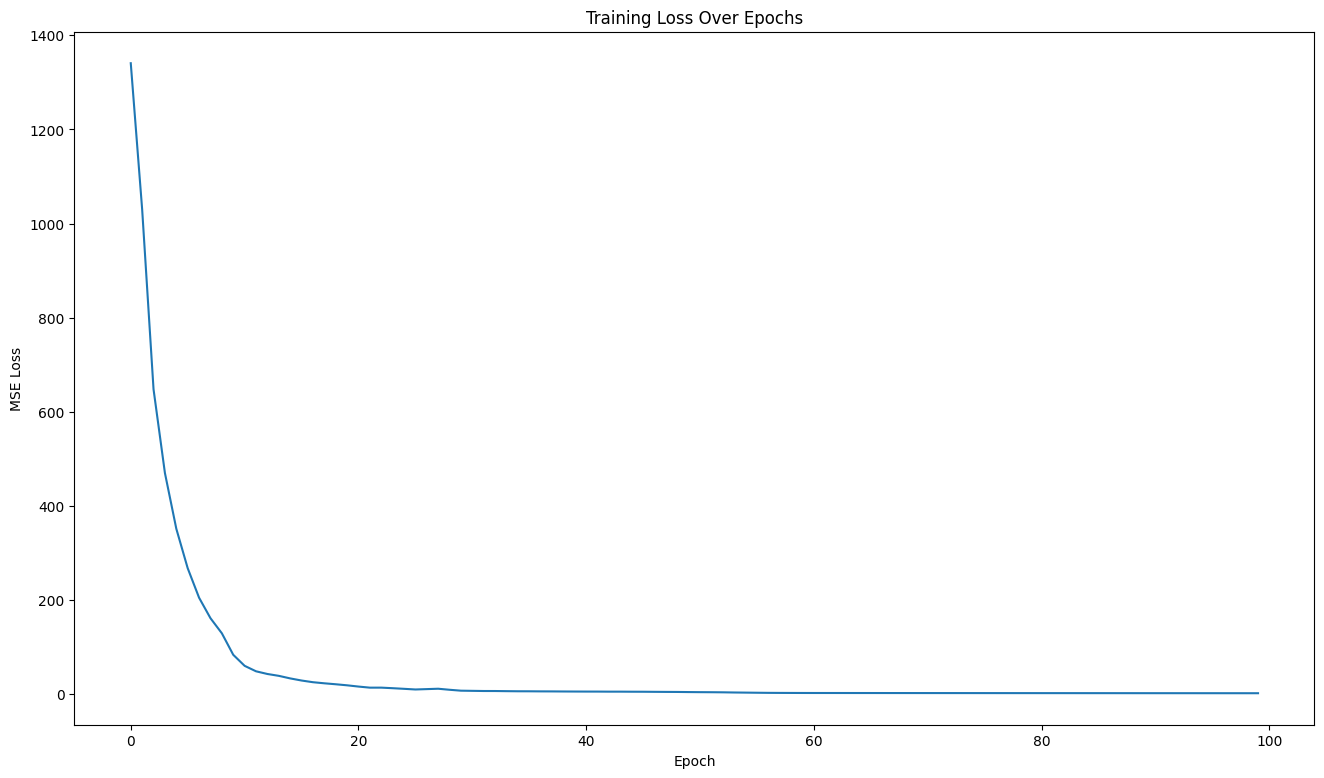

In [7]:
plt.figure(figsize=(16,9))
plt.plot(numpy.arange(0, len(training_losses)), training_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.show()


- Based on the training loop, the model was able get to very close predictions of the data. This is likely due to the fact that the problem requires no splitting shuffling of the dataset and only normalized the data as preprocessing. This in turn allows for a faster convergence and understanding of the distribution of the data.
- Additionally, the data is temporal in nature and the LSTM model is liekly picking up on the long-term pattern as the cell state is preserving the memory of past inputs and outputs.

In [8]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = numpy.ones_like(amazon_stock_series) * numpy.nan
    train_plot = stock_model(train_data.to(device))[:, -1].cpu().numpy()


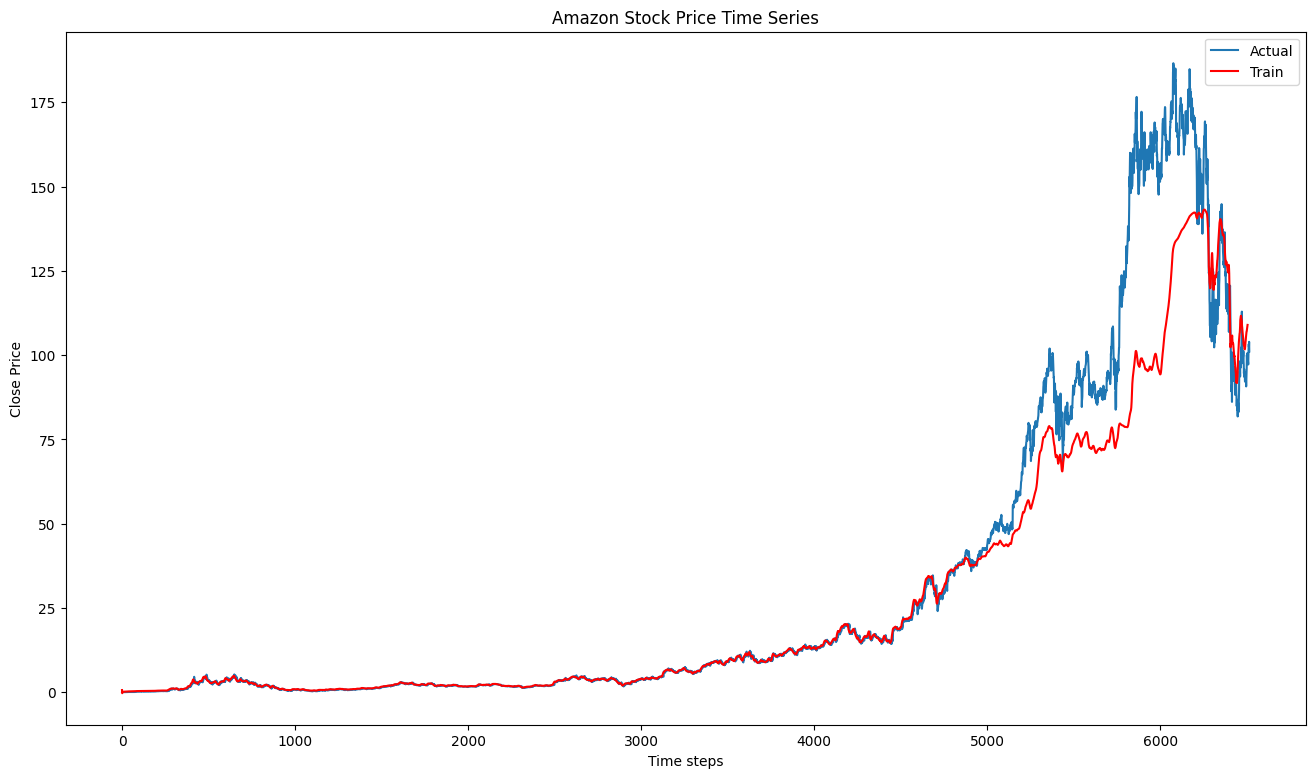

In [9]:
plt.figure(figsize=(16,9))
plt.plot(amazon_stock_series, label="Actual")
plt.plot(train_plot, c='r', label="Train")
plt.xlabel("Time steps")
plt.ylabel("Close Price")
plt.title("Amazon Stock Price Time Series")
plt.legend()
plt.show()


## Question 3
### Consider the lung cancer prediction dataset available on Kaggle, used for a classification task to determine if the patient has cancer or not.

In [8]:
import pandas
from sklearn.model_selection import train_test_split
import torch
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report


#### a) Preprocess the data by converting textual features into numerical values. Split the dataset into train and test sets with a ratio of 7:3.

In [11]:
lung_cancer_dataframe = pandas.read_csv("survey lung cancer.csv")
lung_cancer_dataframe.loc[lung_cancer_dataframe.GENDER == "M", "GENDER"] = 1
lung_cancer_dataframe.loc[lung_cancer_dataframe.GENDER == "F", "GENDER"] = 2
lung_cancer_dataframe.loc[lung_cancer_dataframe.LUNG_CANCER == "NO", "LUNG_CANCER"] = 0
lung_cancer_dataframe.loc[lung_cancer_dataframe.LUNG_CANCER == "YES", "LUNG_CANCER"] = 1
lung_cancer_dataframe = lung_cancer_dataframe.astype(float)

train_data, test_data, train_target, test_target = train_test_split(lung_cancer_dataframe.loc[:, lung_cancer_dataframe.columns != "LUNG_CANCER"].to_numpy(), lung_cancer_dataframe.LUNG_CANCER.to_numpy(), test_size=0.3, train_size=0.7, random_state=42)
train_data_torch = torch.Tensor(train_data)
test_data_torch = torch.Tensor(test_data)
train_target_torch = torch.Tensor(train_target)
test_target_torch = torch.Tensor(test_target)


#### b) Using the sklearn library, train a Support Vector Machine (SVM) for the classification task. Study the performance on the training and testing sets using sklearn’s classification report.

In [18]:
svm_classifier = LinearSVC()
svm_classifier.fit(train_data_torch, train_target_torch)

target_names = ["No", "Yes"]

print("Lung Cancer SVM Prediction Training Results:")

print(classification_report(train_target_torch, svm_classifier.predict(train_data_torch), target_names=target_names))

print("\nLung Cancer SVM Prediction Test Results:")

print(classification_report(test_target_torch, svm_classifier.predict(test_data_torch), target_names=target_names))


Lung Cancer SVM Prediction Training Results:
              precision    recall  f1-score   support

          No       0.78      0.56      0.65        32
         Yes       0.93      0.97      0.95       184

    accuracy                           0.91       216
   macro avg       0.86      0.77      0.80       216
weighted avg       0.91      0.91      0.91       216


Lung Cancer SVM Prediction Test Results:
              precision    recall  f1-score   support

          No       0.83      0.71      0.77         7
         Yes       0.98      0.99      0.98        86

    accuracy                           0.97        93
   macro avg       0.91      0.85      0.88        93
weighted avg       0.97      0.97      0.97        93



- Looking at both of the reports, the SVM classifier seems to be particularly able to correctly identify when somone has lung cancer. It tends to struggle when it comes to correctly identifying when a patient doesn't have lung cancer.
- When looking into precision, similar behavior seems to be at play where the classifier tends to avoid incorrectly labeling when a patient has lung cancer.
- While the overall accuracy seems to be quite good, the finer details of the model reveal a bias towards labeling patients as having lung cancer. 